In [1]:
# Calculate the saltier-layer temperature from TEF and Reflux
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os, sys
sys.path.append(os.path.abspath('../TEF'))
import TEF_Variables as tef

In [ ]:
def reflux(case_id, xi):    

    File1 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase/state_' + str(format(case_id,'03d')) + '.nc')
    State = File1.isel(T=~File1.get_index("T").duplicated())
    Grid = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase/grid_' + str(format(case_id,'03d')) + '.nc')

    state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), T=range(1,len(State.T)))
    grid = Grid.isel(X=range(260), Xp1=range(261), Y=range(35,45))
    s = state.S.data.mean(2) # Salinity in T,Z,X
    u = (state.U.data[:,:,:,1:].mean(2) + state.U.data[:,:,:,:-1].mean(2)) / 2 # Along channel velocity
    ot = state.T.data # Time in seconds


    HFacC1 = grid.HFacC.data.mean(1)
    dyF1 = grid.dyF.data.mean(0)
    drF1 = grid.drF.data
    gridA = np.broadcast_to(drF1[:, np.newaxis], HFacC1.shape) * np.broadcast_to(dyF1[np.newaxis, :], HFacC1.shape) * HFacC1 # Grid Area
    da = np.broadcast_to(gridA[np.newaxis,:,:], u.shape)

    S = state.S.data
    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC
    
    
    Qin = np.empty(len(xi))
    Qout = np.empty(len(xi))
    Sin = np.empty(len(xi))
    Sout = np.empty(len(xi))
    
    t0 = 89 # 274
    # Exclude the upper (surface) layer for TEF calculation
    for t in range(U.shape[0]):
        
        Uzx = u[t,:,:] # Steady-state along-channel velocity
        for j in range(Uzx.shape[1]):
            if any(Uzx[:,j]>0)==False:
                pass
            else:
                mid = np.where(Uzx[:,j]>0)[0][0]
                if mid>0:
                    S[t,:mid,:,j] = 0
                    U[t,:mid,:,j] = 0
                else:
                    pass

#     Uzx = u[t0:,:,:].mean(0) # Steady-state along-channel velocity
#     for j in range(Uzx.shape[1]):
#         if any(Uzx[:,j]>0)==False:
#             pass
#         else:
#             mid = np.where(Uzx[:,j]>0)[0][0]
#             if mid>0:
#                 S[:,:mid,:,j] = 0
#                 U[:,:mid,:,j] = 0
#             else:
#                 pass
    
    
    for i in range(len(xi)):
        
        
        
        tef_q1, tef_vel1, tef_da1, tef_qs1, tef_qs21, sbins1 = tef.process_section(U,S,DA,ot,xi[i],23,testing=False)

        qin1, qout1, sin1, sout1 = tef.bulk_calc(tef_q1, tef_vel1, tef_da1, tef_qs1, tef_qs21, sbins1, ot)
    

        Qin[i] = qin1[t0:].mean() # Time averaging from 1+t0 hour
        Qout[i] = qout1[t0:].mean()
        Sin[i] = sin1[t0:].mean() # Time averaging from 1+t0 hour
        Sout[i] = sout1[t0:].mean()
        
    a002 = (Sin[0]/Sout[0])*(Sout[1]-Sout[0])/(Sout[1]-Sin[0])
    a001 = (Qin[0]-Qin[1]) / Qin[0]    
    a11 = (Sout[1]/Sin[1])*(Sin[1]-Sin[0])/(Sout[1]-Sin[0])    
    a01 = (Sout[1]/Sout[0])*(Sout[0]-Sin[0])/(Sout[1]-Sin[0])
    
    a10 = (Sin[0]/Sin[1])*(Sout[1]-Sin[1])/(Sout[1]-Sin[0])
    
    #a00 = -(Qout[0]/Qin[0])*(Sout[1]-Sout[0])/(Sout[1]-Sin[0])
    #a11 = -(Qin[1]/Qout[1])*(Sin[1]-Sin[0])/(Sout[1]-Sin[0])
    #a01 = (Qin[1]/Qin[0])*(Sout[1]-Sin[1])/(Sout[1]-Sin[0])
    #a10 = (Qout[0]/Qout[1])*(Sout[0]-Sin[0])/(Sout[1]-Sin[0])
    
    q0 = Qin[0]
    q1 = -Qout[-1]
    Q0 = -Qout[0]
    Q1 = Qin[-1]
    f0 = Sin[0]*q0
    f1 = Sout[-1]*q1
    F0 = Sout[0]*Q0
    F1 = Sin[-1]*Q1
    
    A = np.array([[q1, q0, 0, 0], [f1, f0, 0, 0], [0, 0, q1, q0], [0, 0, f1, f0]])
    B = np.array([Q1, F1, Q0, F0])
    X = np.linalg.solve(A,B) # a11, a01, a10, a00
    
    #return a00,q q0, q1, Q0
    #return a001, a002, X[-1]
    return X[0],X[-1],q1,q0,Q1,Q0

In [ ]:
def vol_temp(case_id, xi):
    
    File1 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase/state_' + str(format(case_id,'03d')) + '.nc')
    Grid = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase/grid_' + str(format(case_id,'03d')) + '.nc')  
    State = File1.isel(T=~File1.get_index("T").duplicated())
    
    # Confine to the range of fjord
    state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), T=range(1,len(State.T)))
    grid = Grid.isel(X=range(260), Xp1=range(261), Y=range(35,45))

    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2 # Along-channel velocity
    
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC
    
    rA = np.broadcast_to(grid.rA.data[np.newaxis, np.newaxis, :, :], U.shape)
    CV = rA * drF * HFacC

    
    t0 = 89 # 274
    da = DA[t0:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    cv = CV[t0:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    s = state.S.data[t0:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    temp = state.Temp.data[t0:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    u = U[t0:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    sma = np.ma.masked_where(s==0, s)
    topo = np.ma.getmask(sma) # Masked Topography
    uma = np.ma.MaskedArray(u, mask=topo)
    tma = np.ma.MaskedArray(temp, mask=topo)
    
    #HFacC = grid.HFacC.data
    #CV = np.broadcast_to(grid.drF.data[:, np.newaxis, np.newaxis], HFacC.shape) * np.broadcast_to(grid.rA.data[np.newaxis, :, :], HFacC.shape) * HFacC # Cell Volume
    
    Tv1 = np.empty(uma.shape[1])
    Tv2 = np.empty(uma.shape[1])
    Vol1 = np.empty(uma.shape[1])
    Vol2 = np.empty(uma.shape[1])
    Tvol1 = np.empty(uma.shape[1])
    Tvol2 = np.empty(uma.shape[1])
    
    for i in range(uma.shape[1]):      
        
#         if any(uma[:,i]>0)==False:
#             pass
#         else:
#             mid = np.where(uma[:,i]>0)[0][0]
#             if mid>0:
#                 uma[:mid,i] = 0
#             else:
#                 pass

            
        if any(uma[:,i]<0)==False:
            pass
            
        else:
            #meanS = np.abs(sma[:,i] - (sma[:,i].max() + sma[:,i].min()) / 2)
            #l = np.argmin(meanS)
            l = np.where(uma[:,i] < 0)[-1][0]    
            Tv1[i] = np.sum(tma[:l,i]*da[:l,i]*uma[:l,i]) / np.sum(da[:l,i]*uma[:l,i])
            Tv2[i] = np.sum(tma[l:,i]*da[l:,i]*uma[l:,i]) / np.sum(da[l:,i]*uma[l:,i])
            Vol1[i] = cv[:l,i].sum()
            Vol2[i] = cv[l:,i].sum()
            Tvol1[i] = np.sum(tma[:l,i]*cv[:l,i])
            Tvol2[i] = np.sum(tma[l:,i]*cv[l:,i])
            
        Tf = Tv1[:-1].mean()
        Ts = Tv2[:-1].mean()
        #Tf = Tvol1[:-1].sum()/Vol1[:-1].sum()
        #Ts = Tvol2[:-1].sum()/Vol2[:-1].sum()
        Ts_in = Tv2[-1]
            
    return Tf, Ts, Ts_in
    #return Tv1, Tv2

In [ ]:
qsg = 250
case_n = np.array([1,2,3,4,5])
xrange1 = np.array([5,120]) # 3~47 47~97
xrange2 = np.array([120,235]) # 3~47 47~97

rflx1 = np.empty(len(case_n))
alp111 = np.empty(len(case_n))
alp001 = np.empty(len(case_n))
Qin01 = np.empty(len(case_n))
Qin11 = np.empty(len(case_n))
Qout01 = np.empty(len(case_n))
Ts1 = np.empty(len(case_n))
Tf1 = np.empty(len(case_n))
Ts_in1 = np.empty(len(case_n))


rflx2 = np.empty(len(case_n))
alp112 = np.empty(len(case_n))
alp002 = np.empty(len(case_n))
Qin02 = np.empty(len(case_n))
Qin12 = np.empty(len(case_n))
Qout02 = np.empty(len(case_n))
Ts2 = np.empty(len(case_n))
Tf2 = np.empty(len(case_n))
Ts_in2 = np.empty(len(case_n))



for j in range(len(case_n)):
    
    #alp111[j], alp001[j], Qin11[j], Qin01[j], Qout11, Qout01[j] = reflux(qsg,hs[j],xrange1)
    
    #Tf1[j], Ts1[j], Ts_in1[j] = vol_temp(qsg,hs[j],xrange1)
    
    alp112[j], alp002[j], Qin12[j], Qin02[j], Qout12, Qout02[j] = reflux(case_n[j],xrange2)
    
    Tf2[j], Ts2[j], Ts_in2[j] = vol_temp(case_n[j],xrange2)

In [ ]:
Tse2 = ((Ts_in2)*Qin12*(1-alp112) + (Tf2)*Qin02*alp002) / Qout02
Tr_est = Tse2 / Ts_in2
Tr_obs = Ts2 / Ts_in2
dT_est = Ts_in2 - Tse2
dT_obs = Ts_in2 - Ts2

In [ ]:
dT_est, dT_obs

In [ ]:
hsr = np.array([0.04,0.06,0.08,0.1,0.12])
# Save outputs
Temp_ds = xr.Dataset(
    data_vars={'Tshelf' : Ts_in2,
    'Tfjord_mod' : Ts2,
    'Tfjord_est' : Tse2,
    'hs_h' : hsr})

#outdir = "/Volumes/Extreme SSD/MITgcm outputs/Qsg_comp/"
#outdir = "/Volumes/Extreme SSD/MITgcm outputs/Strat_comp/"
#outdir = "/Volumes/Extreme SSD/MITgcm outputs/Cd_comp/"
outdir = "/home/1959/Parameters/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

Temp_ds.to_netcdf(outdir + 'Ts.nc')

In [ ]:
hsr = [0.04, 0.06, 0.08, 0.10, 0.12]
#fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig1, ax1 = plt.subplots(figsize=(5,5))
plt.grid(linestyle = '--', linewidth = 0.5)

#plt.axis('square')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'$h_s/h$', size=12)
plt.ylabel(r'$T_{fjord}/T_{shelf}$',size=12)

ax1.plot(hsr, Tr_est, 'o-', lw=2,label=r'Estimated')
ax1.plot(hsr, Tr_obs, 'o-', lw=2, label=r'Modeled')
ax1.legend(loc='best', fontsize=12)
ax1.set_ylim([0.9, 1])

ax1.set_xticks([0.04, 0.06, 0.08, 0.10, 0.12])
plt.show()

In [2]:
ds = xr.open_dataset('~/Parameters/FjordModeling/1_BaseCase.nc')

Qin1 = ds.Qin1.data
Qin1_adj = ds.Qin1_adj.data
Qin2 = ds.Qin2.data
Qin2_adj = ds.Qin2_adj.data
Qout1 = ds.Qout1.data
Qout1_adj = ds.Qout1_adj.data
a11 = ds.alpha11.data
a22 = ds.alpha22.data
Tin2 = ds.Ts_in.data
Ts = ds.Ts.data
Tf = ds.Tf.data
#a22[a22<0] = 0
Tse1 = (Tin2*Qin2_adj*(1-a22) + 1.035*Tf*Qin1_adj*a11) / Qout1_adj
Tse2 = (Tin2*Qin2*(1-a22) + Tf*Qin1*a11) / Qout1
Tr_mod = Ts / Tin2
#Tse1[:2] = Tse1[:2]* 1.02
Tr_est = Tse1 / Tin2

In [ ]:
a22, a11

In [9]:
#Tse1, Ts, Tin2
Tr_mod, Tr_est

(array([0.95936279, 0.97446807, 0.98307637, 0.98888129, 0.99274798,
        0.99993913]),
 array([0.94391629, 0.97041797, 0.98458058, 0.99243433, 0.99627709,
        0.99985658]))

In [ ]:
model = np.polyfit(Tse, Ts, 1)
model

In [ ]:
0.49*Tse+5, Ts, 1.02*Tse

In [3]:
corr_matrix1 = np.corrcoef(Tr_mod, Tr_est)
corr1 = corr_matrix1[0,1]
R_sq1 = corr1**2

# corr_matrix2 = np.corrcoef(Ts2, Tse2)
# corr2 = corr_matrix2[0,1]
# R_sq2 = corr2**2

# corr_matrix3 = np.corrcoef(dT_obs, dT_est)
# corr3 = corr_matrix3[0,1]
# R_sq3 = corr3**2

print(R_sq1)

0.9706870631468008


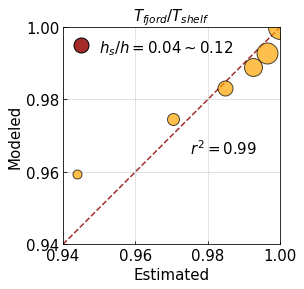

In [4]:
fig2, ax2 =plt.subplots(figsize=(4,4))


ax2.set(xlim=(.94, 1), ylim=(.94, 1))
plt.axis('square')
plt.grid(ls='--', lw=.5)
plt.xlabel(r'Estimated', size=15)
plt.ylabel(r'Modeled', size=15)
ax2.set_yticks([0.94, 0.96, 0.98, 1])
ax2.set_title(r'$T_{fjord}/T_{shelf}$', size=15)
ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", lw=1.5, c="brown")
ax2.tick_params(direction='in', labelsize=15)
loc_mark = [.945, .995]
plt.plot(loc_mark[0],loc_mark[1], marker='o', alpha=1, ms=15, color='brown', markeredgecolor='k')
plt.text(loc_mark[0]+0.005, loc_mark[1]-0.002, r'$h_s/h=0.04\sim0.12$', fontsize=15)
plt.text(.975, .965, r'$r^2=0.99$', fontsize=15)

#for side in ax2.spines.keys():  # 'top', 'bottom', 'left', 'right'
#    ax2.spines[side].set_linewidth(1.5)
#    ax2.spines[side].set_color('red')

for j in range(len(Tr_est)):

    ax2.plot(Tr_est[j], Tr_mod[j], marker='o', alpha=.7, ms=3*(j+3), color='orange', markeredgecolor='k')



Text(0.975, 0.955, '$r^2=0.99$')

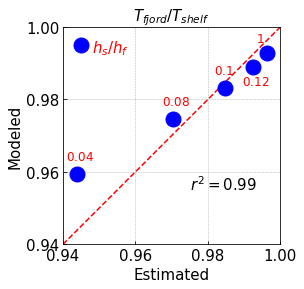

In [19]:
fig3, ax2 =plt.subplots(figsize=(4,4))


ax2.set(xlim=(0.94, 1), ylim=(0.94, 1))
plt.axis('square')
plt.grid(ls='--', lw=.5)
plt.xlabel(r'Estimated', size=15)
plt.ylabel(r'Modeled', size=15)
ax2.set_xticks([0.94, 0.96, 0.98, 1])
ax2.set_yticks([0.94, 0.96, 0.98, 1])
ax2.set_title(r'$T_{fjord}/T_{shelf}$', size=15)
ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", lw=1.5, c="r")
ax2.tick_params(direction='in', labelsize=15)
ax2.plot(Tr_est[:-1], Tr_mod[:-1], 'o', ms=15, c='b')

loc_mark = [.945, .995]
plt.plot(loc_mark[0],loc_mark[1], marker='o', ms=15, color='b')
plt.text(loc_mark[0]+0.003, loc_mark[1]-0.002, r'$h_s/h_f$', color='r', fontsize=15)
label = ['$0.04$', '$0.08$', '$0.1$', '$0.12$', '$1$']
for i in range(len(Tr_est[:-3])):
     plt.text(x=Tr_est[i]-0.003,y=Tr_mod[i]+0.004,s=label[i], 
          fontdict=dict(color='r',size=12))

plt.text(x=Tr_est[-3]-0.003,y=Tr_mod[-3]-0.005,s=label[3], 
          fontdict=dict(color='r',size=12))
plt.text(x=Tr_est[-2]-0.003,y=Tr_mod[-2]+0.003,s=label[4], 
          fontdict=dict(color='r',size=12))

plt.text(.975, .955, r'$r^2=0.99$', fontsize=15)



In [ ]:
fig4 = plt.figure(figsize=(8,4))
fig4.tight_layout()

# Plot Ts
ax1 = fig4.add_subplot(121)
ax1.set(xlim=(8.8, 10), ylim=(8.8, 10))
# square plot
ax1.set_aspect('equal', adjustable='box')
ax1.grid(ls='--', lw=.5)
ax1.set_xlabel(r'Estimated [$^\circ C$]', size=15)
ax1.set_ylabel(r'Modeled [$^\circ C$]', size=15)
ax1.set_title(r'$T_{fjord}$', size=15)
ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", lw=1.5, c="brown")
ax1.tick_params(direction='in', labelsize=12)
loc_mark1 = [8.9, 9.9]
ax1.plot(loc_mark1[0],loc_mark1[1], marker='o', alpha=.7, ms=15, color='blue', markeredgecolor='k')
ax1.text(loc_mark1[0]+0.05, loc_mark1[1]-0.03, r'$h_s/h=0.04\sim0.12$', fontsize=12)
#plt.text(.96, .93, r'$r^2=0.99$', fontsize=12)

for j in range(len(Ts2)):

    ax1.plot(Tse2[j], Ts2[j], marker='o', alpha=.7, ms=3*(j+3), color='orange', markeredgecolor='k')


# Plot Tshelf-Tfjord
ax2 = fig4.add_subplot(122)
ax2.set(xlim=(0, 1), ylim=(0, 1))
ax2.set_aspect('equal', adjustable='box')
ax2.grid(ls='--', lw=.5)
ax2.set_xlabel(r'Estimated [$^\circ C$]', size=15)
ax2.set_ylabel(r'Modeled [$^\circ C$]', size=15)
ax2.set_title(r'$T_{shelf}-T_{fjord}$', size=15)
ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", lw=1.5, c="brown")
ax2.tick_params(direction='in', labelsize=12)
loc_mark2 = [.1, .9]
ax2.plot(loc_mark2[0],loc_mark2[1], marker='o', alpha=.7, ms=15, color='blue', markeredgecolor='k')
ax2.text(loc_mark2[0]+0.05, loc_mark2[1]-0.03, r'$h_s/h=0.04\sim0.12$', fontsize=12)
#plt.text(.96, .93, r'$r^2=0.99$', fontsize=12)

for j in range(len(dT_est)):

    ax2.plot(dT_est[j], dT_obs[j], marker='o', alpha=.7, ms=3*(j+3), color='orange', markeredgecolor='k')

# set the spacing between subplots
plt.subplots_adjust(left=0.05,
                    bottom=0.1, 
                    right=0.95, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.4)
plt.show()

In [ ]:
model = np.polyfit(Tr_est, Tr_obs, 1)
0.4*Tr_est+0.6, Tr_obs

In [ ]:
datapath = '/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase'
def IFA(Hs):
    # Grid areas    
    Area = np.empty([90, 10])
    Area[:20,:] = 400
    Area[20:50,:] = 800
    Area[50:,:] = 1200

    file0 = xr.open_dataset(datapath + '/icefrntA_' + str(format(Hs,'03d')) + '.nc')
    t0 = 0
    tn = 120
    # removed duplicated data caused by model restart
    file = file0.isel(T=~file0.get_index("T").duplicated())
    state = file.isel(Y=range(35,45), T=range(t0,tn))
    
    MR = state.icefrntA.isel(X=1).data.mean(0) # Melt rate at the icefront
    Qsm = (MR*Area).sum()/(24*3600)
    return Qsm

In [ ]:

def icefrntT(case_id):
    File1 = xr.open_dataset(datapath + '/state_' + str(format(case_id,'03d')) + '.nc')
    Grid = xr.open_dataset(datapath + '/grid_' + str(format(case_id,'03d')) + '.nc')  
    State = File1.isel(T=~File1.get_index("T").duplicated())
    
    # Confine to the range of fjord
    state = State.isel(X=range(260), Xp1=range(261), Y=range(35,45), T=range(1,len(State.T)))
    grid = Grid.isel(X=range(260), Xp1=range(261), Y=range(35,45))

    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2 # Along-channel velocity
    
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC
   
    t0 = 0 # Starting time index
    da = DA[t0:,:,:,1].mean(axis=(0,2))
    Ti = state.Temp.data[t0:,:,:,1].mean(axis=(0,2))
    Ui = U[t0:,:,:,1].mean(axis=(0,2))
    
    Tvi = np.sum(Ti*da) / np.sum(da)
    return Tvi

In [ ]:
Qsm = np.empty(len(case_n))
Tice = np.empty(len(case_n))

for j in range(len(case_n)):
    
    Qsm[j] = IFA(case_n[j])
    Tice[j] = icefrntT(case_n[j])

In [ ]:
Qsm, np.sort(Tice)

In [ ]:
fig3, ax3 = plt.subplots(figsize=(5,5))
plt.grid(linestyle = '--', linewidth = 0.5)

#plt.axis('square')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'$T_s$', size=12)
plt.ylabel(r'$Q_{sm}\;[m^3/s]$',size=12)

ax3.plot(np.sort(Tice), np.sort(Qsm), 'o-', lw=2,label=r'$Q_{sg}=250m^3/s$')
ax3.plot(Ts2[:-1], Qsm[:-1], 'o-', lw=2)
ax3.legend(loc='best', fontsize=12)
#ax3.set_xlim([9.5, 10])
#ax1.set_xticks([0.04, 0.06, 0.08, 0.10, 0.12])
plt.show()

In [20]:
fig_path ="/home/1959/Jupyter_Figs/FjordModeling/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
#fig2.savefig(fig_path + '/4-Ts_Comp.png', dpi=200, bbox_inches='tight')
fig3.savefig(fig_path + '/Tfjord.png', dpi=300, bbox_inches='tight') 